In [1]:
# Setup show/hide source code box
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="show/hide source code"></form>''')

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Import everything from the data_utils library
from data_utils import *

# Load the talk data
talk_data = get_only_talks(load_data())

loading conferece_data.pkl


In [8]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('bmh')
prop_cycle = pl.cycler(color=['#377eb8','#e41a1c','#4daf4a','#984ea3',
                              '#ff7f00','#ffff33','#a65628','#f781bf','#999999'])
pl.rcParams.update({
    'axes.prop_cycle': prop_cycle,
    'lines.linewidth': 2,
    'font.size': 20,
    'figure.figsize': [12, 8],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

## References to the current president of the church

In [5]:
apostle_data = load_apostle_data()
cur_apostles = apostle_data[apostle_data['dod'].isna()]['name'].values
president_list = apostle_data[~apostle_data['sdate_p'].isna()]['name']

pres_df = talk_data[['date', 'year', 'decade', 'author', 'president', 'word_count', 'rank', 'author_gender']].copy()
for pr in president_list.values:
    idx = talk_data['president']==pr
    lastname = pr.split(' ')[-1]
    if pr=='Joseph Smith':
        altstr = 'Prophet Joseph(?! Smith)'
    elif lastname=='Smith': # "President Smith" is ambiguous
        altstr = 'President Smith'
    else:
        altstr = 'President ' + lastname
    pres_df[pr] = talk_data['body'].str.count(pr) + \
                  talk_data['body'].str.count(altstr)
    pres_df.loc[idx, 'current'] = talk_data.loc[idx, 'body'].str.count(pr) + \
                                  talk_data.loc[idx, 'body'].str.count(altstr)

yearly_totals = pres_df.groupby('year').sum()[['word_count', 'current']]
yearly_usage_rate = yearly_totals['current']/yearly_totals['word_count']*1e3

In [6]:
# only use data since 1995, when GBH became president
pres_df = pres_df[pres_df['date']>='1995-01-01']

# keep all current apostles, but group all other men and women speakers into 2 categories
pres_df['name'] = pres_df['author'].str.split(' ').str[-1]
pres_df.loc[pres_df['author_gender']=='F', 'name'] = 'other (women)'
pres_df.loc[(pres_df['author_gender']=='M') & (~pres_df['author'].isin(cur_apostles)), 'name'] = 'other (men)'

# calculate totals
pres_data_totals =  pres_df.groupby(['name', 'president']) \
    .sum()[['current', 'word_count']].reset_index()

# pivot to making the 3 presidents of interest the columns
pres_data_totals['ratio'] = pres_data_totals['current']/pres_data_totals['word_count']
results = pres_data_totals.set_index('name').pivot(columns='president', values='ratio')*1e3

# compute the averages and add a separate row
total = pres_df.groupby('president')[['current', 'word_count']].sum()
avg_ratio = total['current']/total['word_count']*1e3
results.loc['average'] = avg_ratio

# order the columns and shorten their names
final = results[['Gordon B. Hinckley', 'Thomas S. Monson', 'Russell M. Nelson']]
final.columns = ['Hinckley', 'Monson', 'Nelson']

# order the rows by getting a seniority list of apostles, and adding the other rows at the end
order = apostle_data[apostle_data['dod'].isna()].sort_values('sdate')['name'].str.split(' ').str[-1] \
    .reset_index().drop('index', 1).reset_index().set_index('name')
order.loc['other (men)', 'index'] = 15
order.loc['other (women)', 'index'] = 16
order.loc['average', 'index'] = 17

final_ordered = final.join(order).sort_values('index').drop('index', 1)

Text(0.5,1,'references to the current president, by speaker,\nduring the Hinckley, Monson & Nelson eras')

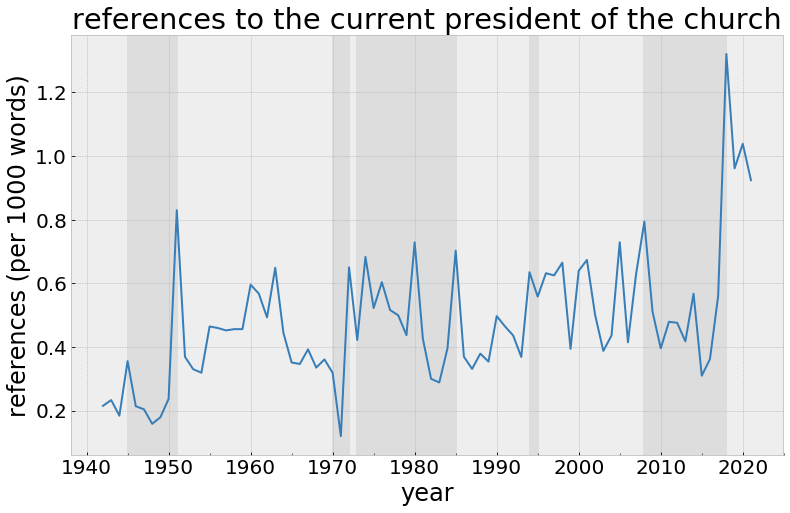

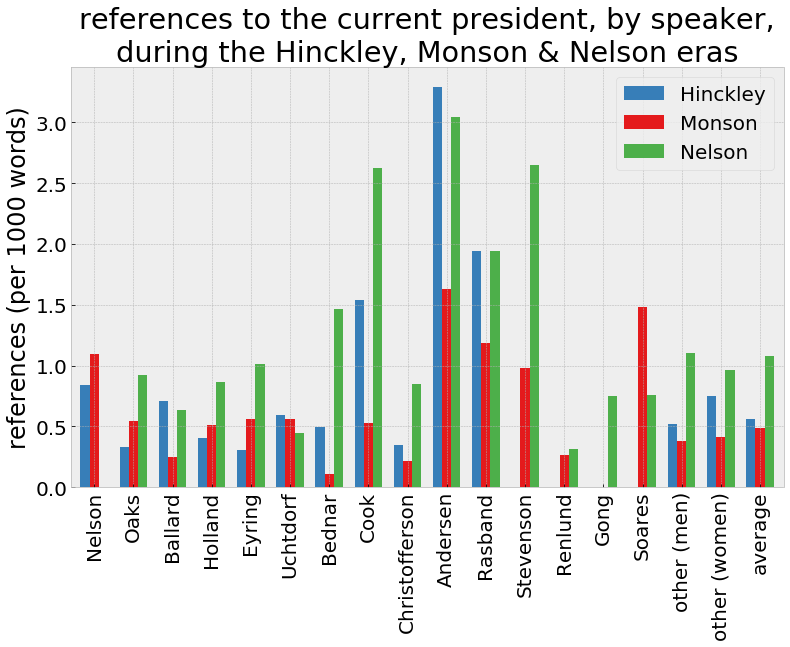

In [9]:
from plot_utils import *

yearly_usage_rate.plot()
pl.title('references to the current president of the church')
pl.ylabel('references (per 1000 words)')
add_president_terms()


ax = final_ordered.plot.bar(width=0.7)
pl.xlabel('')
pl.ylabel('references (per 1000 words)')
pl.title('references to the current president, by speaker,\nduring the Hinckley, Monson & Nelson eras')